<center>

*******************************************************************************************

### Phase-Locking Value

##### 6 April 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* "Phase-locking value" (PLV) is a measure for synchrony of two or more periodic or recurrent signals. In this context, synchrony is defined as a stable phase difference, either in a short lapse of time, or across a number of trials or conditions. The program below evaluates PLV upon a window in time.

>
* References:

    * Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J. (1999). Measuring phase synchrony in brain signals. *Human brain mapping, 8*(4), 194-208. https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C

    *  Mormann, F., Lehnertz, K., David, P., & Elger, C. E. (2000). Mean phase coherence as a measure for phase synchronization and its application to the EEG of epilepsy patients. *Physica D: Nonlinear Phenomena, 144*(3-4), 358-369. https://doi.org/10.1016/S0167-2789(00)00087-7

    * Bruña, R., Maestú, F., & Pereda, E. (2018). Phase locking value revisited: teaching new tricks to an old dog. *Journal of neural engineering, 15*(5), 056011. https://doi.org/10.1088/1741-2552/aacfe4
>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys

sys.path.append(r"..\src")
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:21.0


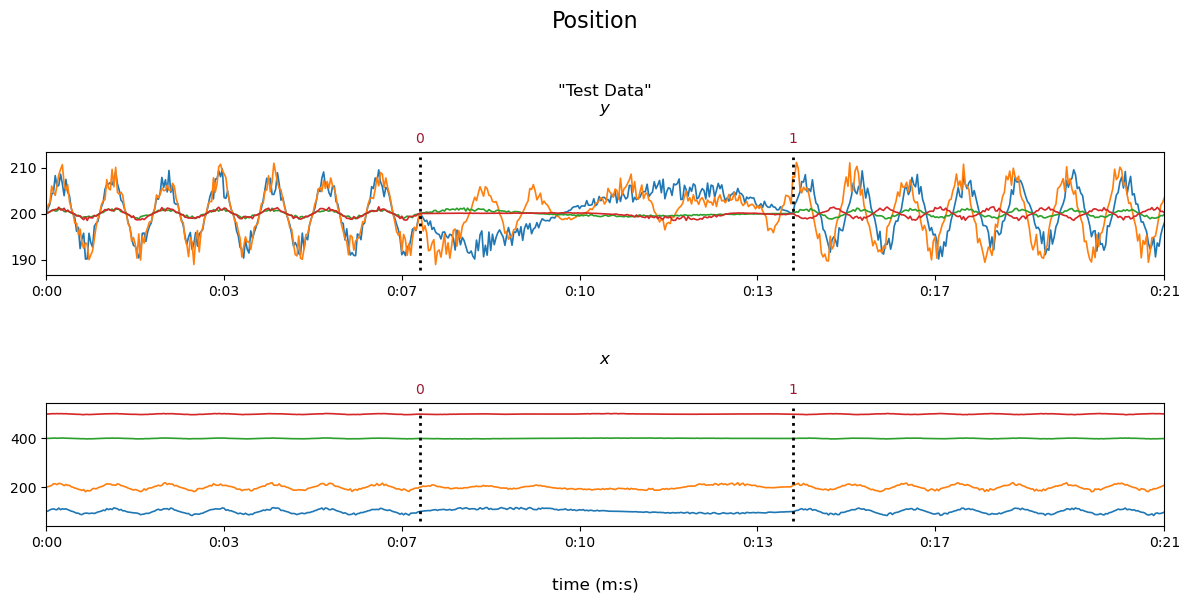

In [2]:
position = sc.ptdata.position( 'make', print_info=True )
position.visualise( vscale=1.2, dlattr='1.2' )

***
### Low-Pass Filter

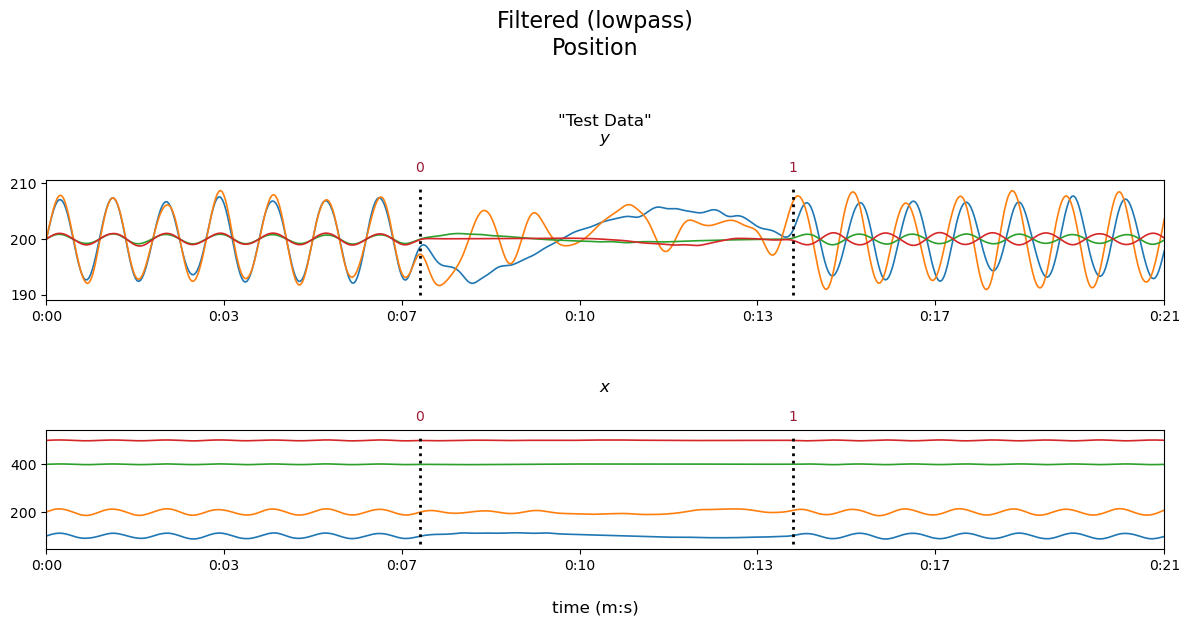

In [3]:
apply_LPF = True # <---

filter_type = 'butter'
filter_freq_response = 'lowpass'
filter_cutoff_freq = 2 # <--- (Hz)
filter_order = 3       # <---

if apply_LPF:
    smooth_pos = sc.ptdata.smooth( position, filter_type=filter_type,
                                   freq_response=filter_freq_response,
                                   cutoff_freq=filter_cutoff_freq, order=filter_order )
    smooth_pos.visualise( vscale=1.2, dlattr='1.2'  )
else:
    smooth_pos = position
    print('Filter not applied.')

***
### Speed

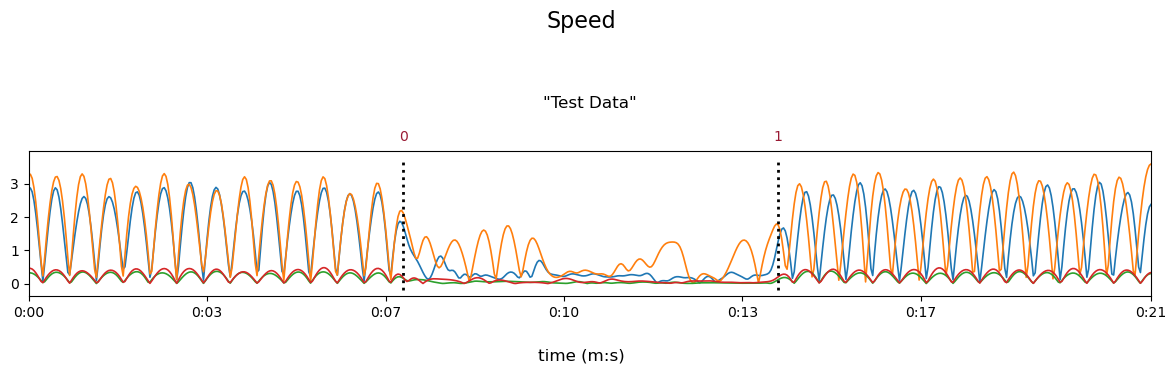

In [4]:
speed = sc.ptdata.apply( smooth_pos, sc.ndarr.tder2D )
speed.visualise( vscale=1.4, dlattr='1.2' )

***
### Phase

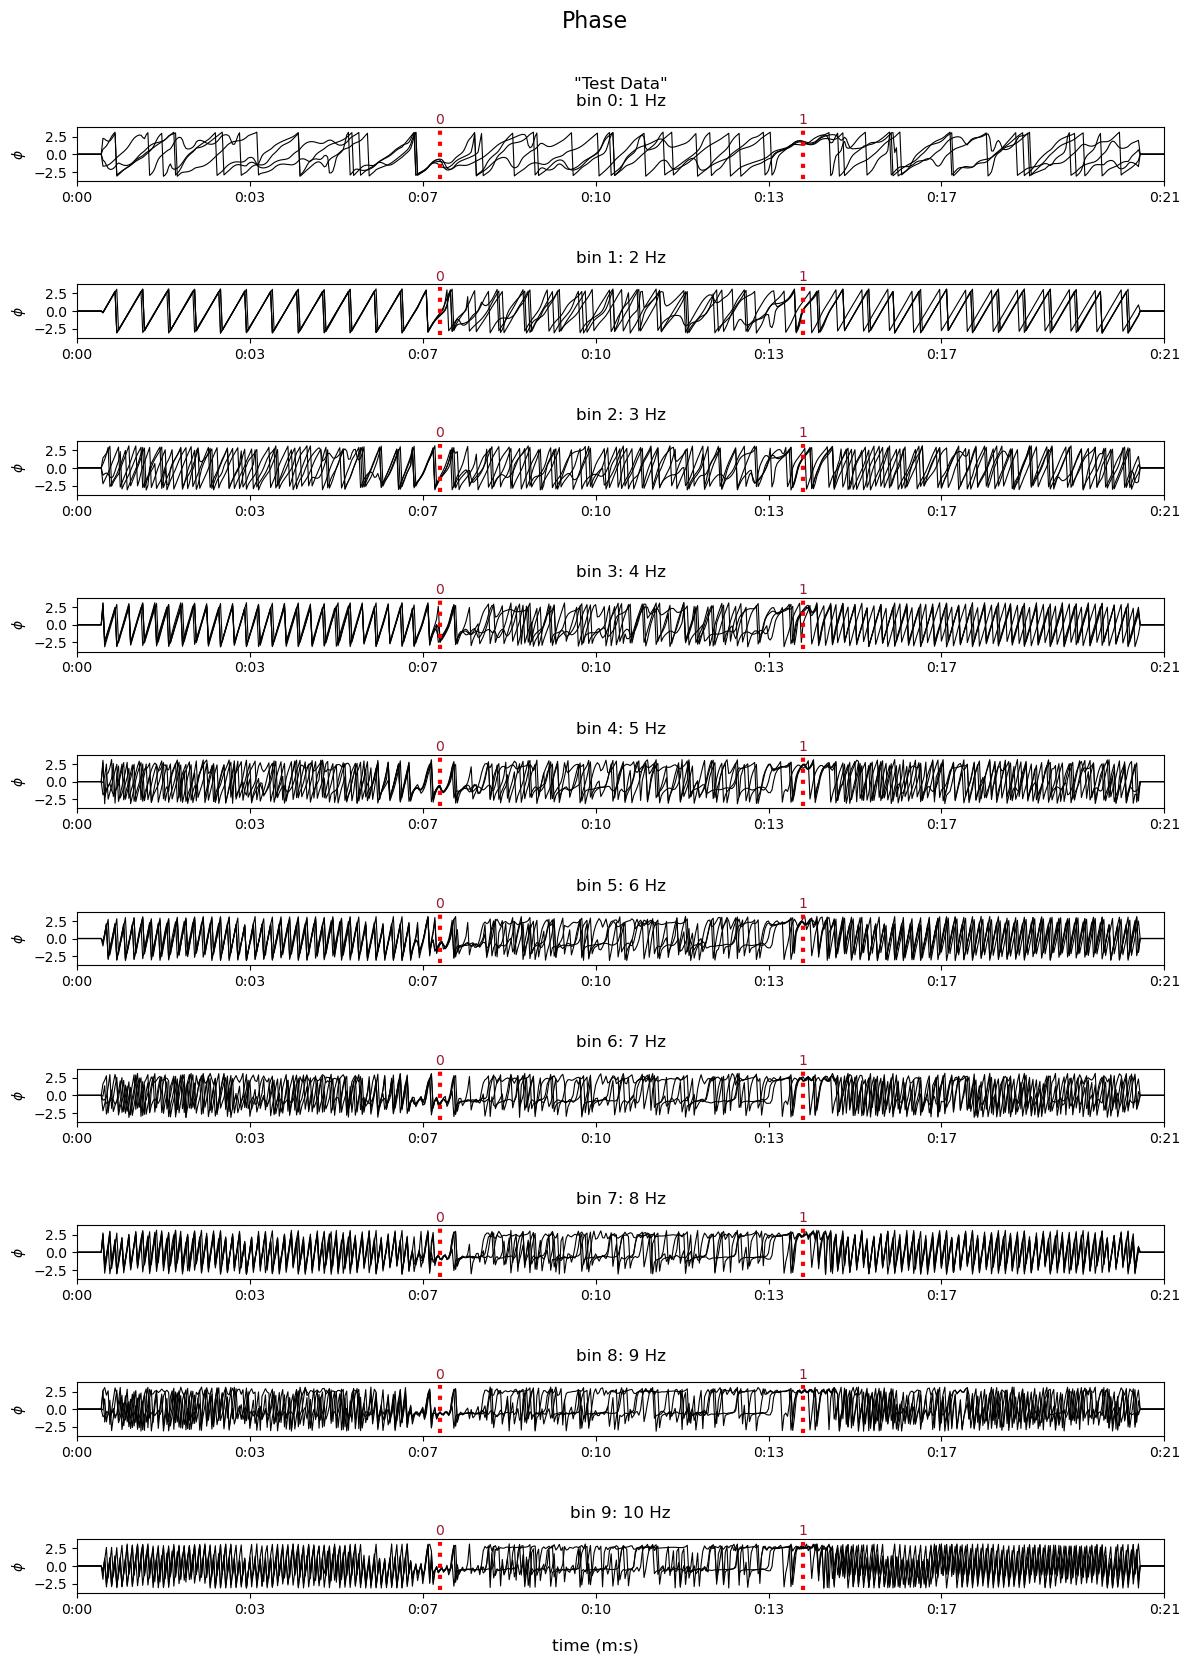

In [5]:
fft_window_s = 1           # <--- FFT window's length (seconds)
sel_freq_bin = slice(0,10) # <--- select frequency bins (int, slice, or 'all')

fft_phase = sc.ptdata.fourier( speed, fft_window_s, output='phase' )
if sel_freq_bin == 'all':
    fft_phase.visualise( vscale=0.7 )
else:
    fft_phase = sc.ptdata.select(fft_phase,frequency=sel_freq_bin)
    if isinstance(sel_freq_bin,slice): fft_phase.visualise( vscale=0.7 )
    else: fft_phase.visualise( vscale=1.3 )

***
### Pairwise PLV

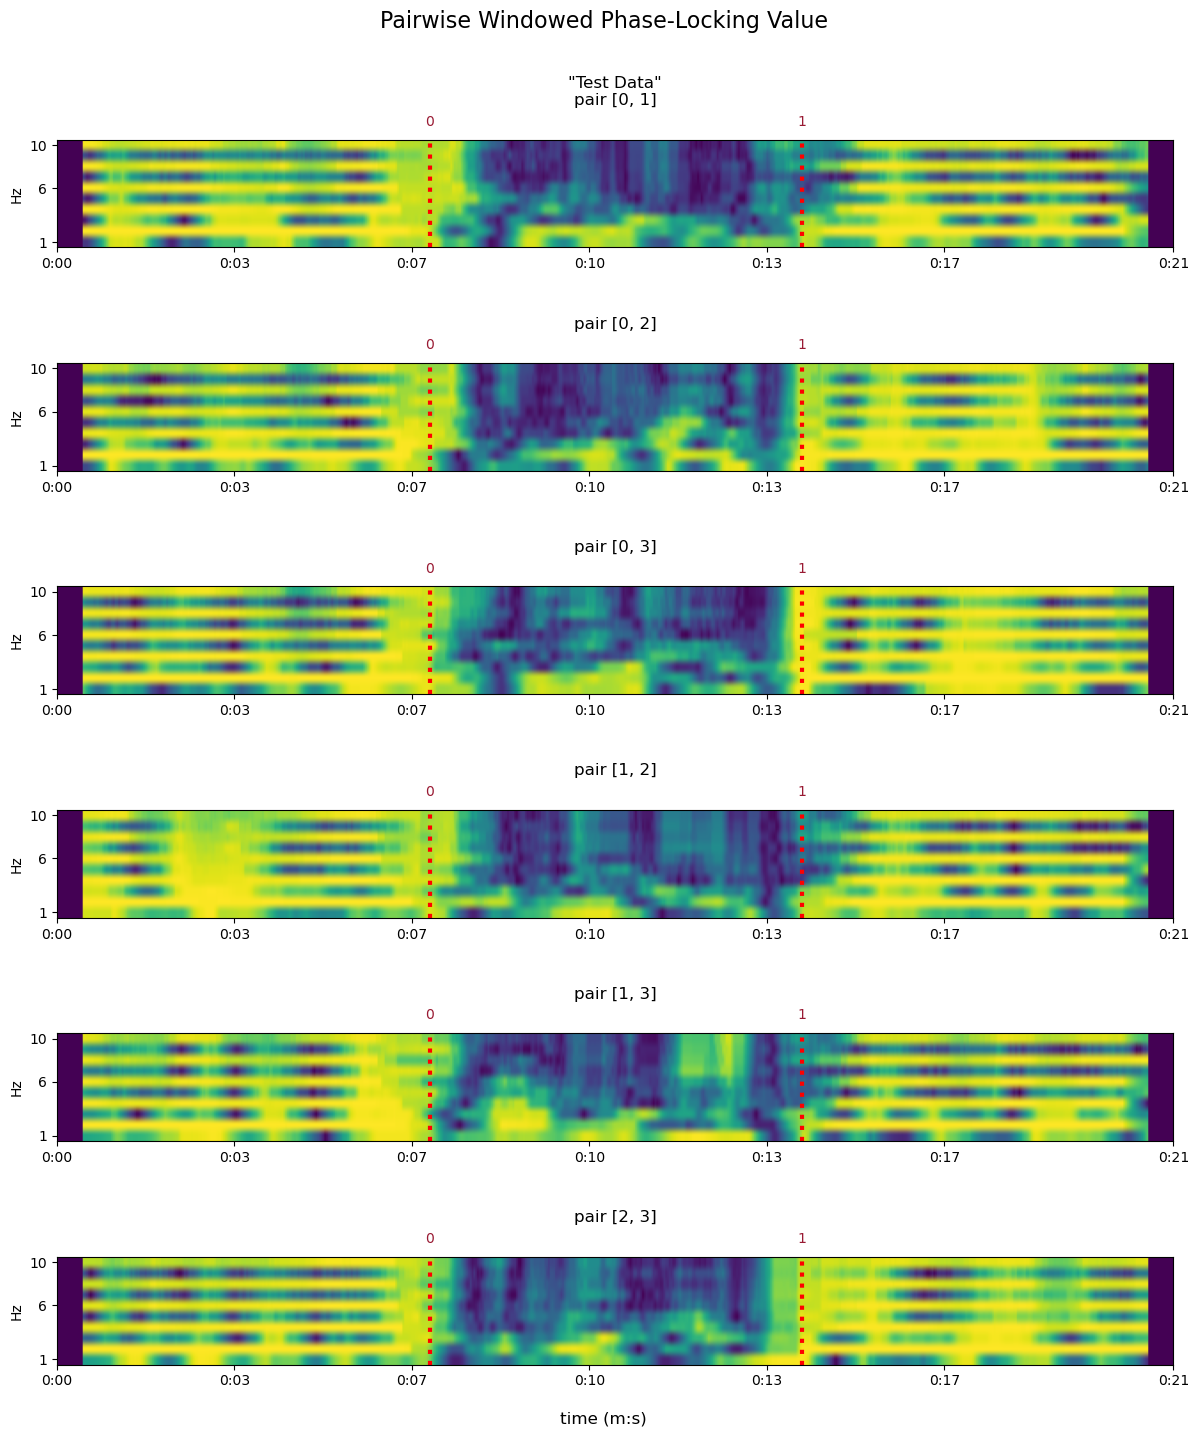

In [6]:
plv_window = 1 # <--- (seconds)

wplv = sc.ptdata.winplv( fft_phase, plv_window )
wplv.visualise( dlattr='1.2' )

>
#### Average PLV for group:

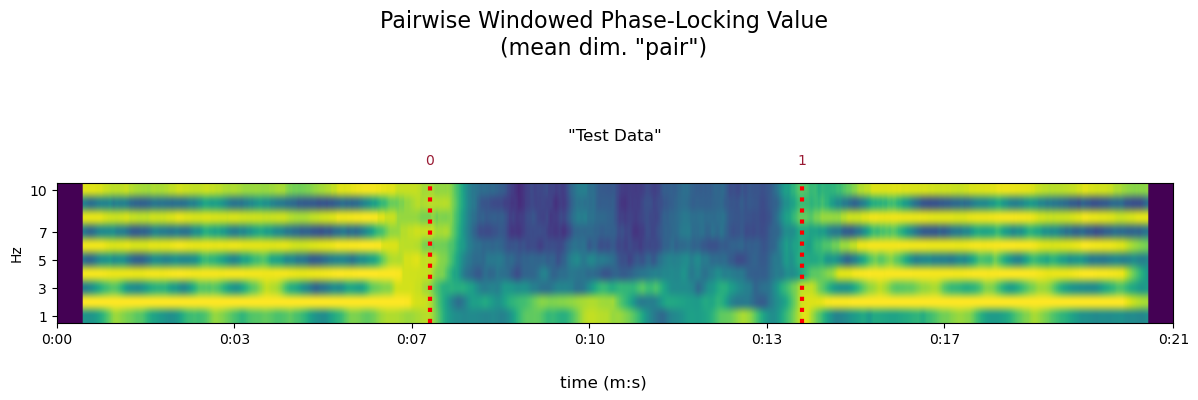

In [7]:
wplv_aggr_pairs = sc.ptdata.aggrax( wplv, axis=0, function='mean' )
wplv_aggr_pairs.visualise( vscale=1.4, dlattr='1.2' )

>
#### Average band-average PLV for group:

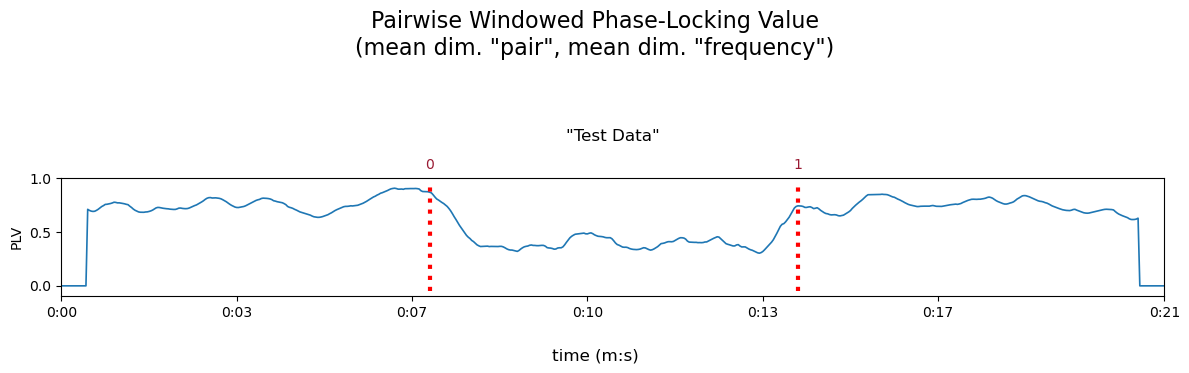

In [8]:
if isinstance(sel_freq_bin,int):
    print('Process does not apply.')
else:
    wplv_aggr_top_sel = sc.ptdata.aggrax( wplv_aggr_pairs, axis=0, function='mean' )
    wplv_aggr_top_sel.visualise( vscale=1.3, vistype='line', dlattr='1.2' )